第一步：数据预处理与语料库构建

In [8]:
import pandas as pd
import jieba
import jieba.posseg as pseg
import os
import re
import time

# ================= 1. 基础配置 =================
INPUT_FILE = os.path.expanduser("/Users/moling/Desktop/policy_text.csv")
OUTPUT_FILE = os.path.expanduser("/Users/moling/Desktop/policy_text纯净版.csv")

# ================= 2. 领域词典定义 (白名单) =================
# 说明：以下词表完全保留原始定义，未做任何增删改

# A. 核心专业词
core_terms = [
    "长期护理保险", "长护险", "医养结合", "失能老人", "居家护理", "定点机构",
    "筹资机制", "经办机构", "两癌筛查", "健康扶贫", "乡村振兴", "兜底保障",
    "特困人员", "慢病管理", "上门服务", "评估标准", "失智老人", "家庭病床",
    "多维贫困", "健康剥夺", "相对贫困", "健康不平等", "健康差距",
    "自评健康", "身体机能", "日常活动能力", "失能风险",
    "空巢老人", "留守老人", "丧偶老人", "独居老人", "高龄女性",
    "照护责任", "隔代照料", "家庭地位", "经济独立", "代际支持",
    "基本公卫", "家庭医生", "签约服务", "分级诊疗", "医疗救助",
    "新农合", "城乡居民基本医疗保险", "大病保险", "报销比例", "自付费用",
    "因病致贫", "因病返贫", "看病难", "卫生室", "村医", "巡诊服务",
    "妇科疾病", "妇女保健", "生殖健康", "更年期", "乳腺癌", "宫颈癌",
    "社区护理", "健康教育", "个人承担", "个人缴费", "费用自付"
]

# B. 数字化趋势词
digital_health_terms = [
    "互联网医疗", "远程医疗", "远程会诊", "远程诊断", "智慧养老",
    "智能穿戴", "信息平台", "数据共享", "一站式结算", "异地结算",
    "电子健康档案", "健康码", "数字鸿沟", "适老化改造", "智能化服务",
    "云平台", "大数据", "信息化", "掌上办", "指尖办", "互联网"
]

# C. 心理健康词
mental_health_terms = [
    "心理健康", "精神健康", "心理疏导", "心理咨询", "心理干预",
    "精神慰藉", "情感支持", "心理关爱", "心理抚慰",
    "抑郁", "孤独感", "空巢", "失落感", "焦虑", "自卑",
    "精神文化生活", "老年教育", "老年大学", "邻里互助", "关爱巡访"
]

# 合并用户字典
user_dict_list = core_terms + digital_health_terms + mental_health_terms

# 加载词典
print("[INFO] 正在初始化分词组件...")
for word in user_dict_list:
    jieba.add_word(word)

# ================= 3. 停用词库定义 (黑名单) =================
# 说明：以下词表仅进行变量分类，内容完全保留原始定义

# (1) 行政动词
admin_stopwords_verbs = [
    "提升", "加快", "推动", "创新", "支持", "强化", "鼓励", "优化", "规范",
    "提供", "进行", "开展", "实施", "落实", "实现", "建立", "健全", "完善",
    "改善", "加强", "制定", "要求", "应当", "符合", "参与", "享受", "办理",
    "导致", "发生", "属于", "作为", "处于", "做好", "推进", "坚持", "全面",
    "深化", "促进", "提高", "加大", "统筹", "保障", "确保", "贯彻", "执行",
    "审核", "审批", "指导", "引导", "情况", "结合", "相关",
    "以及", "组织", "能够", "需要", "公布", "公示", "公告", "受理", "予以",
    "确定", "核定", "审定", "新增", "印发", "评价", "程序", "计划", "规号", "文号"
]

# (2) 干扰类名词
admin_stopwords_nouns = [
    "情况", "信息", "重点", "领域", "方面", "对象", "内容", "项目",
    "制度", "机制", "体系", "措施", "办法", "意见", "通知", "规定",
    "社会", "国家", "全社会", "地方", "试点", "工作", "建设", "发展",
    "质量", "能力", "水平", "技术", "标准", "服务", "需求", "函",
    "有关", "重要", "主要", "部分", "总体", "基本", "综合", "达到",
    "附件", "下载", "名单", "公立", "改革", "我们", "为了", "长护",
    "事业", "中心", "委员", "联合", "年度", "保障局", "医保局", "卫健委",
    "民政局", "财政局", "委员会", "办公室", "履行", "申报", "备案",
    "发放", "申请", "登记", "注册", "报送", "填报", "复核", "计生委",
    "方案", "具体", "及以上", "以下", "单位", "部门", "人员", "岗位",
    "职责", "任务", "目标", "原则", "有限公司", "公司", "企业",
    "方式", "模式", "力度", "优质", "产业", "工程", "政府", "责任",
    "政策", "环境", "战略", "规划", "治理", "构建", "经济", "文化",
    "生态", "生活", "资源", "全民", "国际", "作用", "意义",
    "形成", "行动", "保护", "监测", "监管", "合作", "协调",
    "辖区", "路号", "接受", "皮肤", "注意", "结果", "纳入",
    "卫生局", "卫生健康委", "中医药局", "民政部", "民政厅", "老龄办",
    "老龄委", "老龄工作委员会", "医疗保障局", "社保局", "人社局",
    "人力资源社会保障局", "财政部", "财政厅", "发改委", "发展改革委",
    "行政", "扶贫办", "乡村振兴局", "妇联", "残联", "红十字会", "行政部门",
    "活动", "人群", "给予", "行为", "提出", "条件", "转换", "变更",
    "社会主义", "建立健全", "城乡", "人口", "绿色", "基地"
]

# (3) 特定干扰词
admin_stopwords_specific = [
    "儿童", "少年儿童", "未成年人", "幼儿", "婴幼儿", "学生", "中小学", "托育",
    "职工", "就业", "适用", "使用", "采用", "选择", "协助", "包括", "包含",
    "保持", "操作", "观察", "时间", "时期", "期间", "方法", "路径",
    "手段", "渠道", "处理", "情形", "适龄", "比例", "范围", "手续",
    "探索", "增加", "减少", "降低", "贴近", "发挥", "地区", "解除",
    "人民", "区域", "数量", "实际", "持续", "中止", "材料", "增强",
    "个人", "群众", "不得", "不予", "超过", "机构", "基层", "服务项目",
    "实施方案", "患者", "等", "特色", "合理", "科学", "基础", "应用",
    "更换", "流程", "培育", "行业", "服务业", "控制", "女性", "性别",
    "满足", "出院", "具备", "扩大", "研究", "开放", "推进", "特色",
    "老龄", "问题", "实行", "负责", "资料", "甲方", "乙方", "价格",
    "深入", "设置", "简称", "过程", "参加", "承担", "静脉", "伤口"
]

# (4) 地名黑名单
admin_stopwords_places = [
    "北京", "上海", "天津", "重庆", "青岛", "苏州", "南通", "承德", "长春",
    "齐齐哈尔", "宁波", "安庆", "上饶", "荆门", "广州", "成都", "石家庄", "市北区",
    "盘锦", "晋城", "乌海", "呼和浩特", "松原", "哈尔滨", "大庆", "双鸭山",
    "无锡", "徐州", "常州", "扬州", "镇江", "泰州", "宿迁", "嘉兴", "温州",
    "湖州", "绍兴", "金华", "福州", "开封", "洛阳", "鹤壁", "许昌", "漯河",
    "信阳", "湘潭", "南宁", "北海", "昆明", "曲靖", "乌鲁木齐", "新疆", "兵团",
    "山东", "江苏", "浙江", "河北", "吉林", "黑龙江", "安徽", "江西", "湖北", "广东", "四川",
    "省", "市", "区", "县", "乡", "镇", "村", "街道", "社区", "本市", "我市", "全省"
]

# (5) 基础虚词
base_stopwords = ["的", "了", "在", "是", "和", "对", "等", "及", "与", "年", "月", "日"]

# 合并所有停用词
stop_words = set(
    admin_stopwords_verbs +
    admin_stopwords_nouns +
    admin_stopwords_specific +
    admin_stopwords_places +
    base_stopwords
)

# ================= 4. 同义词处理逻辑 =================
# 说明：基于你原代码中的replace逻辑进行的字典化整理，未增加新词
synonym_dict = {
    "长护险": "长期护理保险",
    "女性": "妇女",
    "新农合": "城乡居民基本医疗保险",
    "城乡居民医保": "城乡居民基本医疗保险",
    "医院": "医疗机构",
    "病情": "疾病",
    "病种": "疾病",
    "农村地区": "农村",
    "农村人口": "农村",
    "照护": "护理",
    "缴纳": "缴费",
    "收费": "缴费"
}

# ================= 5. 核心处理逻辑 =================

def preprocess_text(text):
    """
    文本清洗主函数：同义词替换 -> 正则清洗 -> 词性过滤
    """
    if pd.isna(text):
        return ""
    text = str(text).strip()

    # 同义词替换 (保留原逻辑)
    for old_word, new_word in synonym_dict.items():
        if old_word in text:
            text = text.replace(old_word, new_word)

    # 正则清洗：仅保留中文
    text = re.sub(r'[^\u4e00-\u9fa5]', '', text)

    # 分词与过滤
    words = pseg.cut(text)
    clean_words = []

    for word, flag in words:
        if len(word) < 2: continue
        if word in stop_words: continue

        # 白名单机制
        if word in user_dict_list:
            clean_words.append(word)
            continue

        # 词性筛选 (仅保留名词n和动词v)
        if flag.startswith('n') or flag.startswith('v'):
            if not (flag.startswith('ns') or flag.startswith('nt')):
                clean_words.append(word)

    return " ".join(clean_words)

# ================= 6. 数据流执行 =================

def main():
    start_time = time.time()
    print(f"[INFO] 任务开始: 数据清洗与分词")
    print(f"[INFO] 读取文件: {INPUT_FILE}")

    if not os.path.exists(INPUT_FILE):
        print(f"[ERROR] 文件不存在，请检查路径。")
        return

    df = pd.read_csv(INPUT_FILE)

    # 自动定位正文列
    content_col = "正文"
    if content_col not in df.columns:
        content_col = df.astype(str).applymap(len).mean().idxmax()
        print(f"[WARNING] 未检测到'正文'列，自动选取最长文本列: {content_col}")

    # 执行清洗
    print("[INFO] 开始批处理，请稍候...")
    df['分词结果'] = df[content_col].apply(preprocess_text)

    # 过滤与去重
    print("[INFO] 执行去噪规则：剔除短文本(len<30)与重复项...")
    df_clean = df[df['分词结果'].apply(lambda x: len(x.split()) >= 30)].copy()
    before_len = len(df)

    df_clean.drop_duplicates(subset=['分词结果'], inplace=True)
    after_len = len(df_clean)

    # 保存
    df_clean.to_csv(OUTPUT_FILE, index=False, encoding="utf_8_sig")

    end_time = time.time()
    print("-" * 40)
    print(f"[SUCCESS] 处理完成，耗时 {end_time - start_time:.2f} 秒")
    print(f" - 原始数据: {before_len} 条")
    print(f" - 有效数据: {after_len} 条")
    print(f" - 输出文件: {OUTPUT_FILE}")
    print("-" * 40)

if __name__ == "__main__":
    main()

[INFO] 正在初始化分词组件...
[INFO] 任务开始: 数据清洗与分词
[INFO] 读取文件: /Users/moling/Desktop/剔除干扰词的基础版.csv
[WARNING] 未检测到'正文'列，自动选取最长文本列: v5
[INFO] 开始批处理，请稍候...


/var/folders/p8/k2dk3v013zv_7n49sw97330r0000gn/T/ipykernel_87514/2064768981.py:207: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  content_col = df.astype(str).applymap(len).mean().idxmax()


[INFO] 执行去噪规则：剔除短文本(len<30)与重复项...
----------------------------------------
[SUCCESS] 处理完成，耗时 19.78 秒
 - 原始数据: 450 条
 - 有效数据: 450 条
 - 输出文件: /Users/moling/Desktop/policy_text纯净版.csv
----------------------------------------


第二步：LDA 主题建模与参数寻优

[INFO] 任务启动: LDA 主题建模分析
[INFO] 读取输入文件: /Users/moling/Desktop/policy_text纯净版.csv
[STEP 1/4] 构建语料库...
 - 最终字典特征数: 5715

[STEP 2/4] 执行超参数搜索 (K=[3, 4, 5, 6, 7, 8])...
 - K=3 | Coherence Score=0.5491
 - K=4 | Coherence Score=0.5424
 - K=5 | Coherence Score=0.5569
 - K=6 | Coherence Score=0.5073
 - K=7 | Coherence Score=0.5223
 - K=8 | Coherence Score=0.5275


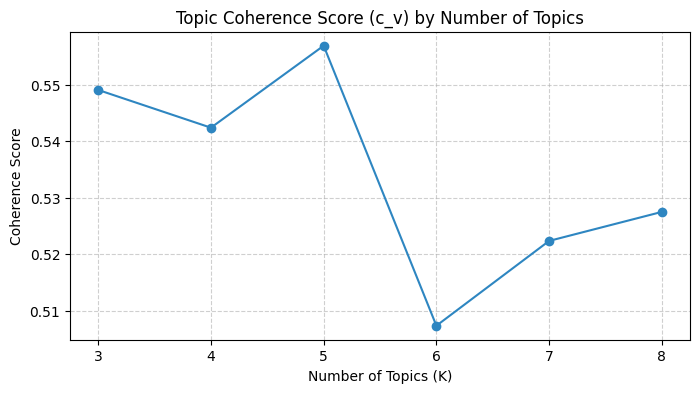


[STEP 3/4] 训练最终模型 (K=5)...
------------------------------
Topic 0: 0.021*"公共卫生" + 0.016*"考核" + 0.015*"宣传" + 0.013*"慢性病" + 0.010*"家庭医生" + 0.010*"医疗卫生" + 0.010*"签约" + 0.010*"签约服务" + 0.010*"检查" + 0.009*"防控"
Topic 1: 0.035*"护士" + 0.024*"互联网" + 0.017*"评估" + 0.015*"培训" + 0.012*"临床" + 0.011*"疾病" + 0.009*"试点工作" + 0.009*"专科" + 0.007*"护理员" + 0.007*"康复"
Topic 2: 0.054*"定点" + 0.045*"长期护理保险" + 0.034*"协议" + 0.027*"参保" + 0.021*"经办机构" + 0.017*"评估" + 0.016*"基金" + 0.015*"费用" + 0.015*"医疗保障" + 0.013*"结算"
Topic 3: 0.023*"老年人" + 0.014*"养老" + 0.014*"妇女" + 0.010*"康复" + 0.009*"医疗卫生" + 0.007*"服务体系" + 0.006*"筛查" + 0.006*"培训" + 0.005*"家庭" + 0.005*"评估"
Topic 4: 0.031*"健康扶贫" + 0.023*"贫困人口" + 0.016*"疾病" + 0.015*"救助" + 0.015*"费用" + 0.015*"建档立卡" + 0.012*"医疗救助" + 0.012*"农村" + 0.012*"资金" + 0.011*"报销"
------------------------------

[STEP 4/4] 生成可视化报告与数据导出...

[SUCCESS] 分析完成，总耗时 39.24 秒
 - 交互式图表: /Users/moling/Desktop/LDA_Result.html
 - 数据明细表: /Users/moling/Desktop/LDA_Data_Analysis.xlsx


In [12]:
import pandas as pd
import gensim
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import os
import time

# ================= 1. 全局配置 =================
INPUT_FILE = os.path.expanduser("/Users/moling/Desktop/policy_text纯净版.csv")
OUTPUT_HTML = os.path.expanduser("/Users/moling/Desktop/LDA_Result.html")
OUTPUT_EXCEL = os.path.expanduser("/Users/moling/Desktop/LDA_Data_Analysis.xlsx")

# 超参数搜索范围
TOPIC_RANGE = range(3, 9)

# 最终确定的 K 值 (根据一致性分数调整)
FINAL_NUM_TOPICS = 5

# 语料特有高频停用词 (Corpus-specific Stopwords)
# 说明：这些词虽然有实际意义，但在本语料中过于泛滥，导致主题间区分度降低
GENERIC_STOPWORDS = ["机构", "服务", "体系", "工作", "建设", "发展"]

# ================= 2. 数据加载与预处理 =================
def main():
    start_time = time.time()
    print(f"[INFO] 任务启动: LDA 主题建模分析")
    print(f"[INFO] 读取输入文件: {INPUT_FILE}")

    if not os.path.exists(INPUT_FILE):
        print(f"[ERROR] 文件不存在，请检查路径。")
        return

    df = pd.read_csv(INPUT_FILE)

    # 1. 基础切分 (假设'分词结果'列已经是空格分隔的字符串或列表字符串)
    # 这里增加一个容错处理，防止读取为非字符串
    print("[STEP 1/4] 构建语料库...")
    data_words = [str(text).split() for text in df['分词结果']]

    # 2. 二次清洗：剔除泛义词
    # 这一步对于提高 Topic Coherence 至关重要
    data_words_clean = []
    for doc in data_words:
        cleaned_doc = [word for word in doc if word not in GENERIC_STOPWORDS]
        data_words_clean.append(cleaned_doc)

    # 3. 构建字典 (Dictionary)
    id2word = corpora.Dictionary(data_words_clean)

    # 4. 过滤极端词频
    # 策略：保留出现不少于3次，且不超过60%文档的词汇
    # 目的：剔除长尾噪音和无区分度的高频词
    id2word.filter_extremes(no_below=3, no_above=0.6)
    print(f" - 最终字典特征数: {len(id2word)}")

    # 5. 构建词袋模型 (BoW)
    corpus = [id2word.doc2bow(text) for text in data_words_clean]

    # ================= 3. 模型参数寻优 (Coherence Check) =================
    print(f"\n[STEP 2/4] 执行超参数搜索 (K={list(TOPIC_RANGE)})...")

    coherence_scores = []

    for k in TOPIC_RANGE:
        # 使用 LdaModel (单核) 以支持 auto 参数优化
        lm = LdaModel(
            corpus=corpus,
            id2word=id2word,
            num_topics=k,
            random_state=42,
            passes=20,       # 增加遍历次数以确保收敛
            alpha='auto',    # 自动学习文档-主题先验分布
            eta='auto',      # 自动学习主题-词先验分布
            eval_every=None  # 关闭实时困惑度评估以提升速度
        )

        cm = CoherenceModel(model=lm, texts=data_words_clean, dictionary=id2word, coherence='c_v')
        score = cm.get_coherence()
        coherence_scores.append(score)
        print(f" - K={k} | Coherence Score={score:.4f}")

    # 绘制一致性分数趋势图
    plt.figure(figsize=(8, 4))
    plt.plot(TOPIC_RANGE, coherence_scores, marker='o', color='#2E86C1')
    plt.title("Topic Coherence Score (c_v) by Number of Topics")
    plt.xlabel("Number of Topics (K)")
    plt.ylabel("Coherence Score")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    # ================= 4. 训练最终模型 =================
    print(f"\n[STEP 3/4] 训练最终模型 (K={FINAL_NUM_TOPICS})...")

    lda_model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=FINAL_NUM_TOPICS,
        random_state=42,
        passes=50,       # 最终模型采用更高轮次，追求稳健性
        iterations=200,  # 提高单次迭代上限
        alpha='auto',
        eta='auto',
        eval_every=None
    )

    # 输出各主题关键词
    print("-" * 30)
    topics = lda_model.print_topics(num_words=10)
    for topic in topics:
        print(f"Topic {topic[0]}: {topic[1]}")
    print("-" * 30)

    # ================= 5. 结果保存与可视化 =================
    print(f"\n[STEP 4/4] 生成可视化报告与数据导出...")

    # A. 导出 pyLDAvis 交互式图表
    vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    pyLDAvis.save_html(vis, OUTPUT_HTML)

    # B. 导出文档-主题分布矩阵
    doc_topics = []
    for i, row in enumerate(lda_model[corpus]):
        # row 格式为 [(topic_id, prob), ...]，按概率降序排列
        row = sorted(row, key=lambda x: x[1], reverse=True)
        if row:
            best_topic_id, prob = row[0]
            # topic_id + 1 是为了符合人类阅读习惯 (1-based index)
            doc_topics.append([best_topic_id + 1, prob])
        else:
            doc_topics.append([0, 0])

    df['Dominant_Topic'] = [x[0] for x in doc_topics]
    df['Topic_Probability'] = [x[1] for x in doc_topics]

    df.to_excel(OUTPUT_EXCEL, index=False)

    end_time = time.time()
    print(f"\n[SUCCESS] 分析完成，总耗时 {end_time - start_time:.2f} 秒")
    print(f" - 交互式图表: {OUTPUT_HTML}")
    print(f" - 数据明细表: {OUTPUT_EXCEL}")

if __name__ == "__main__":
    main()

第三步：定量证据生成与多维可视化（主题词表、柱状图、桑基图）

In [18]:
import pandas as pd
import os
import re
import time
from collections import Counter

# ================= 1. 实验配置 (Configuration) =================

INPUT_FILE = os.path.expanduser("/Users/moling/Desktop/LDA_Data_Analysis.xlsx")
OUTPUT_FILE = os.path.expanduser("/Users/moling/Desktop/Keywords.xlsx")

# [关键参数] 主题定性命名映射表
# 说明：基于LDA模型输出的高频词及代表性文本，人工赋予的社会学意义标签
# ID Mapping: Model_ID -> Qualitative_Label
TOPIC_MAPPING = {
    1: "Topic 5: 基本公共卫生服务均等化与绩效考核",
    2: "Topic 3: 数字健康治理与智慧养老服务供给",
    3: "Topic 2: 长期护理保险制度构建与经办管理",
    4: "Topic 1: 重点人群权益保障与家庭照护支持",
    5: "Topic 4: 多层次医疗保障与防贫兜底机制"
}

# [关键参数] 表格展示层停用词 (Display-layer Stopwords)
# 说明：这些词在模型训练中保留（因为有语义连接作用），但在最终Table 1展示时剔除，
# 以突出"长护险"、"筛查"等具有高区分度的实词。
DISPLAY_STOPWORDS = {
    "服务", "工作", "建设", "发展", "体系", "机构", "项目",
    "加强", "推进", "实施", "开展", "提供", "水平", "能力",
    "群众", "人员", "管理", "保障", "主要", "相关", "不仅",
    "以及", "我们", "要求", "完善", "建立"
}

# ================= 2. 核心处理逻辑 =================

def extract_top_keywords(text_series, top_n=10):
    """
    从文本序列中提取高频特征词
    逻辑：分词 -> 频次统计 -> 剔除展示层停用词 -> 截取TopN
    """
    all_words = []
    # 鲁棒性处理：确保输入为字符串
    for text in text_series.dropna():
        words = str(text).split()
        all_words.extend(words)

    counter = Counter(all_words)

    selected_keywords = []
    # 遍历高频词候选池 (取前50个作为候选)
    for word, freq in counter.most_common(50):
        # 过滤规则：长度>1 且 不在展示屏蔽词表中
        if len(word) > 1 and word not in DISPLAY_STOPWORDS:
            selected_keywords.append(word)

        # 收集满 top_n 个即停止
        if len(selected_keywords) >= top_n:
            break

    return "、".join(selected_keywords)

def main():
    print("[INFO] 任务启动: 生成论文 Table 1 主题词分布表")
    print(f"[INFO] 数据源: {INPUT_FILE}")

    if not os.path.exists(INPUT_FILE):
        print(f"[ERROR] 文件不存在，请检查路径。")
        return

    df = pd.read_excel(INPUT_FILE)

    # 1. 自动定位分词列
    token_col = None
    possible_cols = ['分词结果', '分词', 'tokens', 'processed_text']
    for col in df.columns:
        if any(keyword in str(col) for keyword in possible_cols):
            token_col = col
            break

    if not token_col:
        print("[ERROR] 未在Excel中找到分词列，请检查列名。")
        return

    print(f"[INFO] 锁定分词列: {token_col}")
    print("[INFO] 开始基于映射表进行特征提取...")

    table_data = []

    # 2. 遍历映射表进行聚合
    for model_id, topic_full_name in TOPIC_MAPPING.items():
        # 提取该主题下的子数据集
        subset = df[df['Topic_ID'] == model_id]
        doc_count = len(subset)

        # 提取关键词
        keywords_str = extract_top_keywords(subset[token_col], top_n=10)

        # 解析排序ID (用于最终输出的逻辑排序)
        # 从 "Topic 3: ..." 中提取数字 3
        try:
            sort_id = int(re.search(r'Topic (\d+)', topic_full_name).group(1))
        except AttributeError:
            sort_id = 99 # 异常兜底

        # 清洗主题名称 (去除 "Topic X: " 前缀)
        clean_name = topic_full_name.split(": ")[1] if ": " in topic_full_name else topic_full_name

        table_data.append({
            "Sort_Index": sort_id,
            "原始ID": model_id,
            "主题编号": f"Topic {sort_id}",
            "主题名称": clean_name,
            "高频特征词": keywords_str,
            "文档数量": doc_count
        })

    # 3. 格式化输出
    result_df = pd.DataFrame(table_data)
    # 按论文逻辑顺序 (Topic 1 -> Topic 5) 排序
    result_df = result_df.sort_values(by="Sort_Index")

    # 仅保留论文所需列
    final_output = result_df[["主题编号", "主题名称", "高频特征词", "文档数量"]]

    # 保存
    final_output.to_excel(OUTPUT_FILE, index=False)

    print("-" * 40)
    print(f"[SUCCESS] 处理完成，结果已保存至: {OUTPUT_FILE}")
    print("预览前5行:")
    print(final_output.to_string(index=False))
    print("-" * 40)

if __name__ == "__main__":
    main()

[INFO] 任务启动: 生成论文 Table 1 主题词分布表
[INFO] 数据源: /Users/moling/Desktop/LDA_Data_Analysis.xlsx
[INFO] 锁定分词列: 分词结果
[INFO] 开始基于映射表进行特征提取...
----------------------------------------
[SUCCESS] 处理完成，结果已保存至: /Users/moling/Desktop/Keywords.xlsx
预览前5行:
   主题编号             主题名称                                   高频特征词  文档数量
Topic 1  重点人群权益保障与家庭照护支持      护理、老年人、医疗、医疗机构、妇女、养老、医疗卫生、培训、康复、筛查    67
Topic 2  长期护理保险制度构建与经办管理   护理、定点、长期护理保险、协议、参保、经办机构、评估、费用、基金、医疗保障   109
Topic 3  数字健康治理与智慧养老服务供给        护理、医疗机构、护士、医疗、互联网、评估、临床、培训、疾病、专科    95
Topic 4   多层次医疗保障与防贫兜底机制 医疗机构、健康扶贫、医疗、贫困人口、费用、疾病、救助、建档立卡、农村、医疗救助   105
Topic 5 基本公共卫生服务均等化与绩效考核 护理、医疗机构、公共卫生、健康扶贫、宣传、考核、慢性病、老年人、医疗卫生、医疗    74
----------------------------------------


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ================= 1. 实验配置 (Configuration) =================

INPUT_FILE = os.path.expanduser("/Users/moling/Desktop/LDA_Data_Analysis.xlsx")
OUTPUT_FIG_INTENSITY = os.path.expanduser("/Users/moling/Desktop/Chart_1_Intensity_Fixed.png")
OUTPUT_FIG_VOLUME = os.path.expanduser("/Users/moling/Desktop/Chart_2_Volume_Fixed.png")

# [关键参数] 主题元数据配置
# 说明：建立模型原始ID与论文语义标签、排序及视觉方案的映射关系
# Structure: {Original_Model_ID: {Sort_Order, Label_Name, Color_Hex}}
TOPIC_METADATA = {
    4: {"sort": 1, "name": "T1\n权益保障", "color": "#D32F2F"},  # 红色高亮 (核心关注)
    3: {"sort": 2, "name": "T2\n长护险制度", "color": "#90A4AE"}, # 辅助色 (灰色)
    2: {"sort": 3, "name": "T3\n数字治理", "color": "#90A4AE"},
    5: {"sort": 4, "name": "T4\n防贫兜底", "color": "#90A4AE"},
    1: {"sort": 5, "name": "T5\n公卫服务", "color": "#90A4AE"}
}

# ================= 2. 数据聚合与处理 (Data Aggregation) =================

print("[INFO] Loading dataset and calculating metrics...")

if not os.path.exists(INPUT_FILE):
    print(f"[ERROR] File not found: {INPUT_FILE}")
    exit()

df = pd.read_excel(INPUT_FILE)

# 聚合计算各主题的平均概率强度 (Intensity) 和 文档数量 (Volume)
topic_stats = df.groupby('Topic_ID')['Topic_Prob'].agg(['mean', 'count']).reset_index()

# 构建绘图数据集
# 仅提取在配置文件中定义的主题，并关联元数据
viz_data = []
for _, row in topic_stats.iterrows():
    tid = row['Topic_ID']
    if tid in TOPIC_METADATA:
        meta = TOPIC_METADATA[tid]
        viz_data.append({
            "Topic_Label": meta["name"],
            "Mean_Prob": row['mean'],
            "Count": row['count'],
            "Color": meta["color"],
            "Sort_ID": meta["sort"]
        })

# 转换为DataFrame并按预定义的逻辑顺序排序 (T1 -> T5)
df_viz = pd.DataFrame(viz_data).sort_values(by="Sort_ID")

# ================= 3. 可视化生成 (Visualization) =================

def generate_bar_chart(data_series, y_label, title, save_path, is_probability=False):
    """
    生成并保存柱状图
    :param data_series: 绘图数据列
    :param y_label: Y轴标签
    :param title: 图表标题
    :param save_path: 保存路径
    :param is_probability: 是否为概率值 (影响数值标签格式化)
    """
    plt.figure(figsize=(10, 6))

    # 设置字体以支持中文显示 (MacOS环境)
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
    plt.rcParams['axes.unicode_minus'] = False

    # 绘制柱状图
    bars = plt.bar(
        df_viz["Topic_Label"],
        data_series,
        color=df_viz["Color"],
        width=0.6,
        edgecolor='white',
        linewidth=0.5
    )

    # 添加数值标签
    for bar in bars:
        height = bar.get_height()
        # 格式化数值：概率保留4位小数，计数保留整数
        label_str = f"{height:.4f}" if is_probability else f"{int(height)}"

        plt.text(
            bar.get_x() + bar.get_width() / 2.,
            height,
            label_str,
            ha='center',
            va='bottom',
            fontsize=12,
            fontweight='bold'
        )

    # 图表修饰
    plt.title(title, fontsize=14, pad=20, fontweight='bold')
    plt.ylabel(y_label, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.3) # 增加淡色网格线辅助阅读

    # 保存文件
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"[INFO] Chart saved: {save_path}")
    plt.close()

# ================= 4. 执行输出 =================

# 图 1: 政策聚焦度 (Intensity) - 对应 Mean Probability
generate_bar_chart(
    df_viz["Mean_Prob"],
    "平均概率强度 (Average Probability)",
    "图 1：农村健康贫困治理各主题的政策聚焦度 (Intensity)",
    OUTPUT_FIG_INTENSITY,
    is_probability=True
)

# 图 2: 政策覆盖量 (Volume) - 对应 Document Count
generate_bar_chart(
    df_viz["Count"],
    "政策文本数量 (Number of Documents)",
    "图 2：农村健康贫困治理各主题的政策覆盖量 (Volume)",
    OUTPUT_FIG_VOLUME,
    is_probability=False
)

print("[SUCCESS] All visualizations generated successfully.")

[INFO] Loading dataset and calculating metrics...
[INFO] Chart saved: /Users/moling/Desktop/Chart_1_Intensity_Fixed.png
[INFO] Chart saved: /Users/moling/Desktop/Chart_2_Volume_Fixed.png
[SUCCESS] All visualizations generated successfully.


In [20]:
# ================= 附录：Sankey 图数据流生成 =================
# 说明：这段代码不直接画图，而是生成 SankeyMATIC 网站所需的格式化数据流
# 逻辑：Python 计算数值 -> 打印字符串 -> 复制到 SankeyMATIC 渲染
import pandas as pd
import os
import re

# ================= Configuration =================

# Input file path
FILE_PATH = os.path.expanduser("/Users/moling/Desktop/LDA_Data_Analysis.xlsx")

# Visualization Colors (SankeyMATIC)
COLOR_HIGHLIGHT = "#D32F2F"   # Red (Focus Topic)
COLOR_PRIMARY   = "#1565C0"   # Blue (Standard Nodes)
COLOR_FLOW_BG   = "#90A4AE"   # Grey (Background Flows)

OPACITY_HIGH    = ".85"
OPACITY_LOW     = ".6"

# Topic ID Mapping
# Mapping raw model IDs to finalized paper labels
topic_map = {
    4: "T1 权益保障",  # Original ID: 4
    3: "T2 长护险制度", # Original ID: 3
    2: "T3 数字治理",  # Original ID: 2
    5: "T4 防贫兜底",  # Original ID: 5
    1: "T5 公卫服务"   # Original ID: 1
}

# ================= Data Preprocessing =================

print(f"[INFO] Reading data from: {FILE_PATH}")
df = pd.read_excel(FILE_PATH)

# 1. Year Extraction
# Fallback to column index 2 if 'v3' is missing
year_col = 'v3' if 'v3' in df.columns else df.columns[2]

def extract_year(val):
    match = re.search(r'20\d{2}', str(val))
    return int(match.group()) if match else None

df['Year_Clean'] = df[year_col].apply(extract_year)
df = df.dropna(subset=['Year_Clean'])

# 2. Period Classification
def get_period(year):
    if 2016 <= year <= 2020:
        return "脱贫攻坚期 (2016-2020)"
    elif year >= 2021:
        return "乡村振兴期 (2021-2025+)"
    return None

df['Period'] = df['Year_Clean'].apply(get_period)
df = df.dropna(subset=['Period'])

# 3. Data Aggregation
sankey_data = df.groupby(['Period', 'Topic_ID']).size().reset_index(name='Count')

# ================= Output Generation =================

print("-" * 40)
print("[OUTPUT] SankeyMATIC Logic String")
print("-" * 40)

# A. Define Node Colors
print(f":T1 权益保障 {COLOR_HIGHLIGHT}")

# Batch define standard topic colors
standard_topics = ["T2 长护险制度", "T3 数字治理", "T4 防贫兜底", "T5 公卫服务"]
for name in standard_topics:
    print(f":{name} {COLOR_PRIMARY}")

# Define period node colors
print(f":脱贫攻坚期 (2016-2020) {COLOR_PRIMARY}")
print(f":乡村振兴期 (2021-2025+) {COLOR_PRIMARY}")

# B. Generate Flow Data
period_order = ["脱贫攻坚期 (2016-2020)", "乡村振兴期 (2021-2025+)"]

for period in period_order:
    current_data = sankey_data[sankey_data['Period'] == period]

    for _, row in current_data.iterrows():
        tid = row['Topic_ID']

        if tid in topic_map:
            topic_name = topic_map[tid]
            count = row['Count']

            # Apply visual logic: Highlight T1, fade others
            if topic_name == "T1 权益保障":
                color = COLOR_HIGHLIGHT
                opacity = OPACITY_HIGH
            else:
                color = COLOR_FLOW_BG
                opacity = OPACITY_LOW

            # Output format: Source [Amount] Target Color.Opacity
            print(f"{period} [{count}] {topic_name} {color}{opacity}")

print("-" * 40)
print(f"[INFO] Process complete. Valid records used: {len(df)}")

[INFO] Reading data from: /Users/moling/Desktop/LDA_Data_Analysis.xlsx
----------------------------------------
[OUTPUT] SankeyMATIC Logic String
----------------------------------------
:T1 权益保障 #D32F2F
:T2 长护险制度 #1565C0
:T3 数字治理 #1565C0
:T4 防贫兜底 #1565C0
:T5 公卫服务 #1565C0
:脱贫攻坚期 (2016-2020) #1565C0
:乡村振兴期 (2021-2025+) #1565C0
脱贫攻坚期 (2016-2020) [44] T5 公卫服务 #90A4AE.6
脱贫攻坚期 (2016-2020) [41] T3 数字治理 #90A4AE.6
脱贫攻坚期 (2016-2020) [42] T2 长护险制度 #90A4AE.6
脱贫攻坚期 (2016-2020) [30] T1 权益保障 #D32F2F.85
脱贫攻坚期 (2016-2020) [85] T4 防贫兜底 #90A4AE.6
乡村振兴期 (2021-2025+) [30] T5 公卫服务 #90A4AE.6
乡村振兴期 (2021-2025+) [53] T3 数字治理 #90A4AE.6
乡村振兴期 (2021-2025+) [67] T2 长护险制度 #90A4AE.6
乡村振兴期 (2021-2025+) [37] T1 权益保障 #D32F2F.85
乡村振兴期 (2021-2025+) [15] T4 防贫兜底 #90A4AE.6
----------------------------------------
[INFO] Process complete. Valid records used: 444
